In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from lsdlib import read_input
import astropy.units as u
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, LinearLocator, FixedLocator
from glob import glob
import os
#from array_utils import get_ind

plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('text', usetex=True)

plt.rc('xtick',  labelsize='x-large')
plt.rc('ytick',  labelsize='x-large')
plt.rc('axes', labelsize='xx-large')
plt.rc('text', usetex=True)

In [7]:
##Loading info
#
qso = ascii.read("templates/z75qso.dat")
wave_mu = qso['lambda_mu']/ (1+7.5)

#starburst99 model
s99 = ascii.read("templates/starburst99_host_models_z75_lines.txt") 
wave_host_mu = s99['wave'] / (1+7.5)

flux = qso['flux_mjy'] 
flux_host = s99["300Myr_0.2"]

nirspec = {"G140H/F070LP":{"wmin":.7, "wmax":1.27, "ypos":0.52},
           "G140H/F100LP":{"wmin":.97, "wmax":1.89, "ypos":0.71},
           "G235H/F170LP":{"wmin":1.66, "wmax":3.17, "ypos":0.52},
           "G395H(M)/F290LP":{"wmin":2.87, "wmax":5.27, "ypos":0.71}
        }

miri = {
        "SHORT1":{"wmin":4.89, "wmax":5.75, "ypos":0.78},
        "SHORT2":{"wmin":7.49, "wmax":8.78, "ypos":0.78},
        "SHORT3":{"wmin":11.53, "wmax":13.48, "ypos":0.78},
        "SHORT4":{"wmin":17.66, "wmax":20.92, "ypos":0.78}, 
        "MEDIUM1":{"wmin":5.65, "wmax":6.64, "ypos":0.61},
        "MEDIUM2":{"wmin":8.65, "wmax":10.14, "ypos":0.61},
        "MEDIUM3":{"wmin":13.37, "wmax":15.63, "ypos":0.61},
        "MEDIUM4":{"wmin":20.54, "wmax":24.4, "ypos":0.61}, 
        "LONG1":{"wmin":6.52, "wmax":7.66, "ypos":0.43},
        "LONG2":{"wmin":9.99, "wmax":11.71, "ypos":0.43},
        "LONG3":{"wmin":15.44, "wmax":18.05, "ypos":0.43},
        "LONG4":{"wmin":23.95, "wmax":28.45, "ypos":0.43}, 
}

In [12]:
nircam_path = "filters/jwst/nircam_throughputs/modAB_mean/nrc_plus_ote/"
nircam_wide = glob(nircam_path + "F*W_*txt")
nircam_medium = glob(nircam_path + "F*M_*txt")
nircam_narrow = glob(nircam_path + "F*N_*txt")

miri_path = 'filters/jwst/miri/'
miri_filters = glob(miri_path + "J*dat")

### plotting stuff


In [13]:
def plot_lines(line_label, line_wave, line_yloc, ax, redshift=6.0):
    zp1 = 1+redshift
    for w, l, y in zip(line_wave, line_label, line_yloc):
        ax.text(w * zp1, y, l, horizontalalignment='center', fontsize='large')

In [14]:

def plot_nircam_filters(ax):
    plot_filterset(ax, nircam_wide, 'xkcd:blue', 0.1)
    plot_filterset(ax, nircam_medium, 'xkcd:coral', 0.25)
    plot_filterset(ax, nircam_narrow, 'xkcd:lime', 0.4)
    

In [15]:
def plot_filterset(ax, filenames, color, yloc, miri=False):
    text_kwargs = dict(fontsize='x-large', ha='center', va='center', weight='black')
    for filename in filenames:
        d = ascii.read(filename)
        b = os.path.basename(filename)
        if miri:
            wave = d['angstrom']/1e4
            name = b.split(".")[1]
#             print(wave)
        else:
            wave = d['microns']
            name = b.split("_")[0]
        
        xloc = np.float(name[1:-1])/100.
        
        ax.fill_between(wave, d['throughput'], edgecolor=color, facecolor=color, alpha=0.3)
        ax.plot(wave, d['throughput'], color=color, alpha=0.4)
        #ax.text(xloc, yloc, name, color=color, **text_kwargs)
        

In [34]:
def plot_setup(ax, setup, color):
    for name in setup:
        di  = setup[name]
        ax.hlines(di["ypos"], di["wmin"], di["wmax"], color=color, lw=2, alpha=0.5)
        xx = ( di["wmin"] + di["wmax"]) * 0.5
        ax.text(xx, di["ypos"]+0.01, name, color=color, ha='center', fontsize='medium')
        


In [17]:
def plot_qso(ax, redshift):
    zp1=1+redshift
    ax.plot(wave_mu * zp1, flux*1.2, color='xkcd:black',lw=3, zorder=2)
    
    
def plot_host(ax, redshift, factor=1):
    zp1=1+redshift
    ax.plot(wave_host_mu * zp1, flux_host * factor, color='xkcd:orange',lw=3, zorder=1)

In [32]:
def plot_nirspec_panel(ax1, ax2, redshift):
    #xaxis
    x1ticks = np.arange(0.5, 5.5, 0.5)
    xmin = 0.6
    xmax = 5.3
    minorLocatorx= FixedLocator(np.arange(0.75, 5.5, 0.25))  
    for a in [ax1, ax2]:
        a.set_xticks(x1ticks)
        a.xaxis.set_minor_locator(minorLocatorx)
        a.set_xlim(xmin, xmax)
        #plt.setp(a, yticks=[])
    #yaxis
    plt.setp(ax2, xticklabels=[])
    plt.setp(ax1, yticklabels=[], yticks=[])
    # ax1.locator_params(axis='y', nbins=3)
    
    ax2.set_ylabel("$\mathrm{Spectrum\\ (mJy)}$")
    
    ##UPPER PANEL
    plot_qso(ax2, redshift)
    #host
    plot_host(ax2, redshift, factor=30)
    ax2.text(4.5, 0.06, r"$\mathrm{Host }$", color='xkcd:orange', 
             fontsize="xx-large", weight='bold')
    #Plot lines
    line_label = [ r'Ly$\alpha$+N$\,$V', r'C$\,$IV', r'Mg$\,$II',
                  r'C$\,$III] + Fe$\,$III', r'H$\,\beta$' + r'+ [O$\,$III]']
    line_wave = [1270/1e4-0.01, 1546.15/1e4, 2800.26/1e4, 
                 1905.97/1e4, 4835/1e4+0.01]
    line_yloc = [0.13, 0.15 ,.15,.12, 0.18]
    plot_lines(line_label, line_wave, line_yloc, ax=ax2, redshift=redshift)
    
    ax2.set_ylim(0.035,0.2)
    
    #LOWER PANEL
    ax1.set_ylim(0., 0.85)
    ax1.set_ylabel("$\mathrm{Filters}$")
    ax1.set_xlabel(r'$\mathrm{Wavelength}\; (\mu{\rm m})$')
    #Plot NIRCAM filters
    plot_nircam_filters(ax1)
    
    
    plot_setup(ax1, nirspec, color='xkcd:blue')

In [33]:
def plot_miri_panel(ax1, ax2, redshift):
    #xaxis
    xmin = 5
    xmax = 30
    x1ticks = np.arange(xmin, xmax, 5)
    
    minorLocatorx= FixedLocator(np.arange(xmin, xmax, 1))  
    for a in [ax1, ax2]:
        a.set_xticks(x1ticks)
        a.xaxis.set_minor_locator(minorLocatorx)
        a.set_xlim(xmin, xmax)
        #plt.setp(a, yticks=[])
    #yaxis
    #plt.setp(ax2, yticks=[],xticklabels=[])
    plt.setp(ax2, xticklabels=[])
    plt.setp(ax1, yticklabels=[], yticks=[])
    #ax1.locator_params(axis='y', nbins=3)
    
    ax2.set_ylabel("$\mathrm{Spectrum\\ (mJy)}$")
    
    ##UPPER PANEL
    plot_qso(ax2, redshift)
    #host
    plot_host(ax2, redshift, factor=30)
    ax2.text(24, 0.05, r"$\mathrm{Host }\times 30$", color='xkcd:orange', 
              fontsize="xx-large", weight='bold')
    ax2.text(3.3 * (1+redshift) -2., 0.5, r"$3.3\,\mu m\, \mathrm{PAH}$", color='xkcd:orange', 
            fontsize='x-large')
    #Plot lines
    line_label = [ r'H$\, \alpha$', r'Pa$\, \alpha$',   r'Pa$\, \beta$', r'Pa$\, \gamma+\delta$']
    line_wave = [6564.93/1e4, 1.87,  1.28, 1.06, ]
    line_yloc = [0.3, 0.26, 0.26, 0.26, 0.26]
    plot_lines(line_label, line_wave, line_yloc, ax=ax2, redshift=redshift)
    
    ax2.set_ylim(0.01 ,0.35)#1.)
    
    #LOWER PANEL
    ax1.set_ylim(0., 0.85)
    ax1.set_ylabel("$\mathrm{Filters}$")
    ax1.set_xlabel(r'$\mathrm{Wavelength}\; (\mu{\rm m})$')

    
    plot_filterset(ax1, miri_filters, color='xkcd:purple', yloc=0.45, miri=True)
    
    plot_setup(ax1, miri, color='xkcd:red')


In [28]:
def plot_jwst_qso(redshift, out=None):
    fig = plt.figure(figsize=(12, 8.))
    #x0, y0 dx dy
    bottom = 0.1
    left = 0.1
    h_w = 0.8
    v_w = 0.21
    sep= 0.09

    ax1 = fig.add_axes([left, bottom, h_w, v_w])
    ax2 = fig.add_axes([left, bottom+v_w, h_w, v_w])
    ax3 = fig.add_axes([left, bottom+2*v_w+sep, h_w, v_w])
    ax4 = fig.add_axes([left, bottom+3*v_w+sep, h_w, v_w])


    plot_nirspec_panel(ax3, ax4, redshift=redshift)
    plot_miri_panel(ax1, ax2, redshift=redshift)
    ax4.set_title("$\mathrm{Quasar\\ at\\ }z="+"{0:.4f}$".format(redshift), fontsize=20)


    if out is not None:
        plt.savefig(out+'.pdf', bbox_inches='tight', dpi=300)


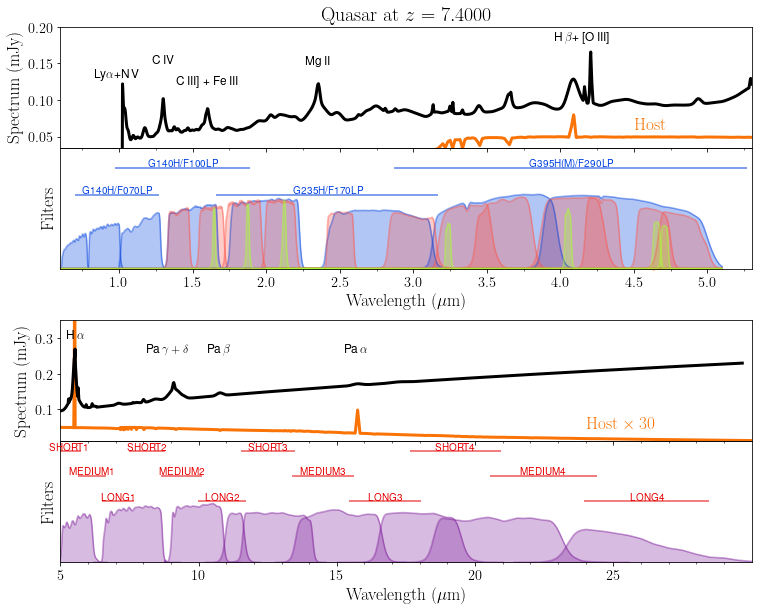

In [37]:
plot_jwst_qso(7.4, 'test')